<a href="https://colab.research.google.com/github/gabilodeau/INF8770/blob/master/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF8770 Technologies multimédias

Polytechnique Montréal

Author: Soufiane Lamghari




Description : Ce notebook implémente Mask R-CNN pour la segmentation d'instances (et la détection d'objets), en utilsant ResNet50 comme réseau de base (pré-entrainé sur les 80 classes de MS COCO). Dans cet exmple, on prédit le masque pour quelques images.

Import libraries

In [1]:
import torchvision.models as models
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import urllib.request as request
import random
import cv2
from PIL import Image
from skimage import io

Téléchargement des images (ici du github de INF8770) et on les transforme en tenseurs torch.

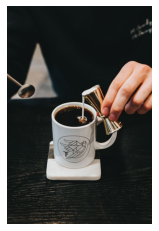

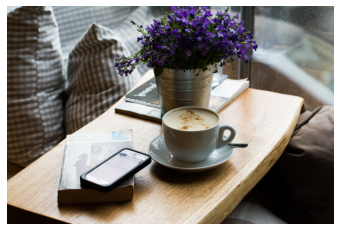

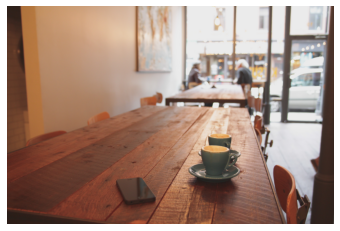

In [2]:
source = 'https://raw.githubusercontent.com/gabilodeau/INF8770/master/images'
examples = ['coffee0.jpg', 'coffee1.jpg', 'coffee2.jpg']

tensors = []
preprocess = transforms.Compose([transforms.ToTensor()])

for example in examples:
  img = io.imread(os.path.join(source, example))
  tensors.append(preprocess(img))
  plt.imshow(img); plt.axis('off'); plt.show()

Téléchargement des étiquettes de classes (ici du github de INF8770)

In [3]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF8770/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
  COCO_NAMES.append(label_name.strip().decode('UTF-8'))

Chargement du modèle et obtention des prédictions. 

In [4]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()
predictions = model(tensors)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Exemples de masques prédits, un exemple pour chaque image (celui avec le score le plus élevé).

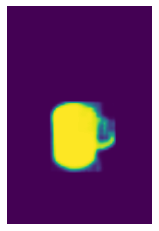

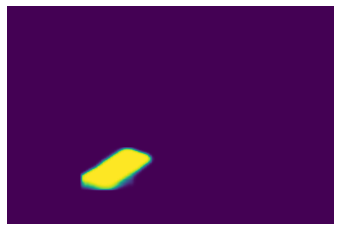

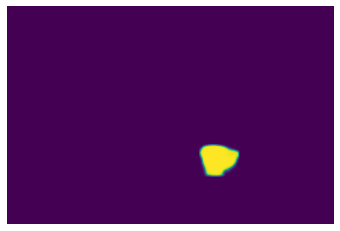

In [5]:
for prediction in predictions:
    mask = prediction['masks'][0][0].detach().numpy()

    plt.imshow(mask); plt.axis('off'); plt.show()

Fonction pour dessiner les masques sur les images.

In [6]:
def draw_colored_masks(image):
  name_colors=list(mcolors.CSS4_COLORS.keys())
  name_colors.remove('black')
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  rgb_color = rgb_colors[random.randrange(0,len(rgb_colors))]
  r[image > 0.5], g[image > 0.5], b[image > 0.5] = rgb_color
  colored_mask = np.stack([r, g, b], axis=2)
  return colored_mask, rgb_color

Seuil pour décider si une prédiction est assez bonne pour être retenue. Peut être modifié.

In [7]:
THRESHOLD = 0.95

Affichage des prédictions sur les images. Une prédiction inclut le masque, le rectangle englobant, une étiquette de classe, et un niveau de confiance (plus grand que le seuil).

nbobjects (over threshold):  2


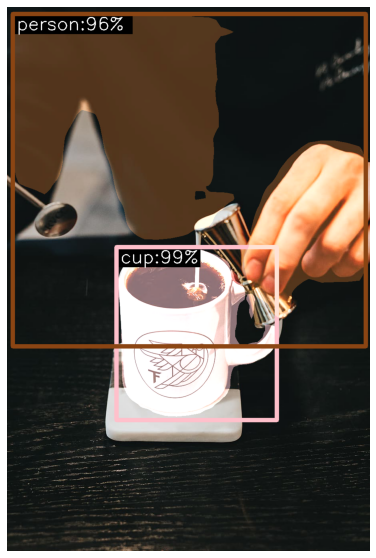

nbobjects (over threshold):  5


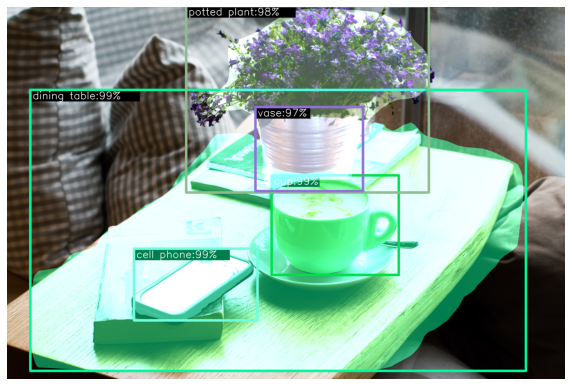

nbobjects (over threshold):  7


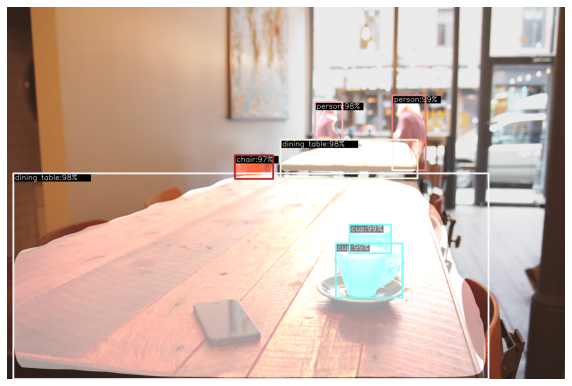

In [8]:
for i, prediction in enumerate(predictions):
  img = tensors[i].permute(1,2,0).mul(255).byte().numpy() # permute est equivalent a faire deux tranpose : ici permute(1,2,0) peut etre remplacee par transpose(0, 1).transpose(1, 2)

  nb_objects=0
  for j, score in enumerate(prediction['scores']):
      if score >= THRESHOLD:
        
        mask = prediction['masks'][j][0].detach().numpy()
        colored_mask, color = draw_colored_masks(mask)
        label=prediction['labels'][j]
        x1,y1,x2,y2 = prediction['boxes'][j]
        

        img = cv2.addWeighted(img, 1, colored_mask, 0.5, 0)
        label_score=COCO_NAMES[label]+':{}%'.format(str(int(score.item()*100)))
        img = cv2.rectangle(img, (x1+5, y1+5), (x1+len(label_score)*30, y1+50), (0,0,0), -1)
        img = cv2.putText(img, label_score, (x1+10, y1+40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color.tolist(), 10)
        

        nb_objects+=1

  print('nbobjects (over threshold): ', nb_objects)

  plt.figure(figsize = (10,10))
  plt.imshow(img); plt.axis('off'); plt.show()

**References:**
 - https://pytorch.org/docs/stable/torchvision/models.html

 - [Mask R-CNN paper](https://arxiv.org/abs/1703.06870)